In [1]:
import pandas as pd 
import openpyxl
import numpy
from func import transform_df 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df = pd.read_excel('data/table2-20-21.xlsx', skiprows=13, sheet_name='Provider')
df = df.iloc[10:1290]
df_20_21 = transform_df(df, 2020, 2021)

# table 2 2021 - 2022

df = pd.read_excel('data/table2-21-22.xlsx', skiprows=13, sheet_name='Provider')
df = df.iloc[10:1278]
df_21_22 = transform_df(df, 2021, 2022)

# table 2 2022 - 2023
df = pd.read_excel('data/table2-22-23.xlsx', skiprows=13, sheet_name='Provider')
df = df.iloc[10:1270]
df_22_23 = transform_df(df, 2022, 2023)

# table 2 2023-2024

df = pd.read_excel('data/table2-23-24.xlsx', skiprows=13, sheet_name='Provider')
df = df.iloc[10:1240]
df_23_24 = transform_df(df, 2023, 2024)


# combine each year into one df 
df = pd.concat([df_20_21, df_21_22, df_22_23, df_23_24])
df = df.dropna()
df = df[df.MedianWaitDays != '.']
df = df[df.MedianWaitDays != '*']

# I think its easier to just focus on 3 modalities, but i'm also okay to do all of them if that's either of your preference. 
# Choosing PET, MRI & CT because those were mentioned in proposal

modalities = ['Magnetic Resonance Imaging', 'Positron Emission Tomography', 'Computerized Axial Tomography']
years = [2019, 2020, 2021]
df = df[df['Modality'].apply(lambda x: any(m in x for m in modalities))]
df = df[df['Year'].apply(lambda x: x>=2020)]
df = df[df['Year'].apply(lambda x: x<2023)]



df_pet = df[df.Modality == 'Positron Emission Tomography']
df_mri =  df[df.Modality == 'Magnetic Resonance Imaging']
df_pet.Date = df_pet.Date.dt.to_timestamp()
df_ct = df[df.Modality == 'Computerized Axial Tomography']
df_mri.Date = df_mri.Date.dt.to_timestamp()
df_ct.Date = df_ct.Date.dt.to_timestamp()


/var/folders/nd/1p3rzcrj77xgxtcymgf3pkzw0000gn/T/ipykernel_634/87972528.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pet.Date = df_pet.Date.dt.to_timestamp()
/var/folders/nd/1p3rzcrj77xgxtcymgf3pkzw0000gn/T/ipykernel_634/87972528.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mri.Date = df_mri.Date.dt.to_timestamp()
/var/folders/nd/1p3rzcrj77xgxtcymgf3pkzw0000gn/T/ipykernel_634/87972528.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [3]:
from statsmodels.tsa.stattools import adfuller

In [5]:
orgs= df_mri['Org Code'].unique()

results = {"p_val":[], 
          'org_code':[], 
          'stationary':[]}

for org in orgs:
    

    data = df_mri[df_mri['Org Code']==org]
    data = data['MedianWaitDays']
    if data.nunique() >1 and len(data)>3:
        
        result = adfuller(data, autolag='AIC')
        results['p_val'].append(result[1])
        results['org_code'].append(org)
        if result[1]<0.05:
            results['stationary'].append(True)
        else:
            results['stationary'].append(False)

res_mri = pd.DataFrame(results)
res_mri

,p_val,org_code,stationary
0,1.881334e-01,NT9,False
1,1.063198e-01,RF4,False
2,3.509132e-01,R1H,False
3,1.984728e-02,NT4,True
4,2.770098e-02,RQM,True
...,...,...,...
151,1.512424e-03,NN4,True
152,4.398993e-02,R0D,True
153,1.836099e-01,NYR,False
154,3.294846e-02,DCM,True


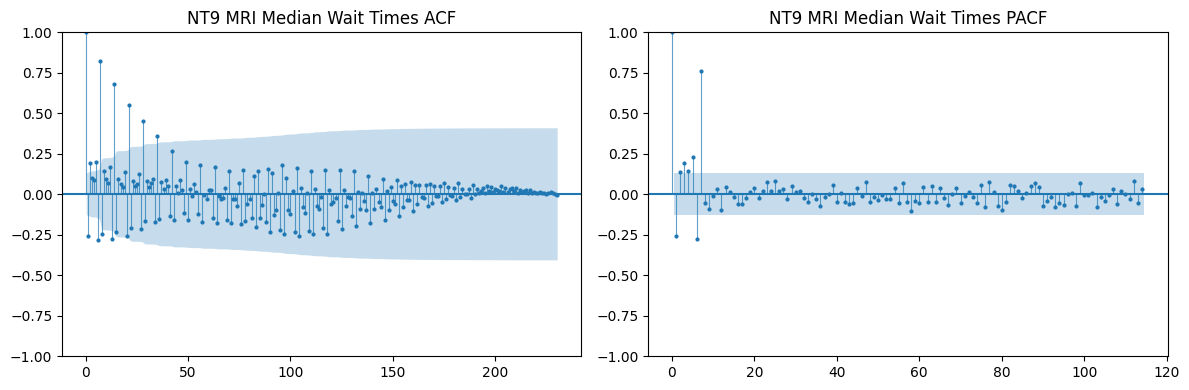

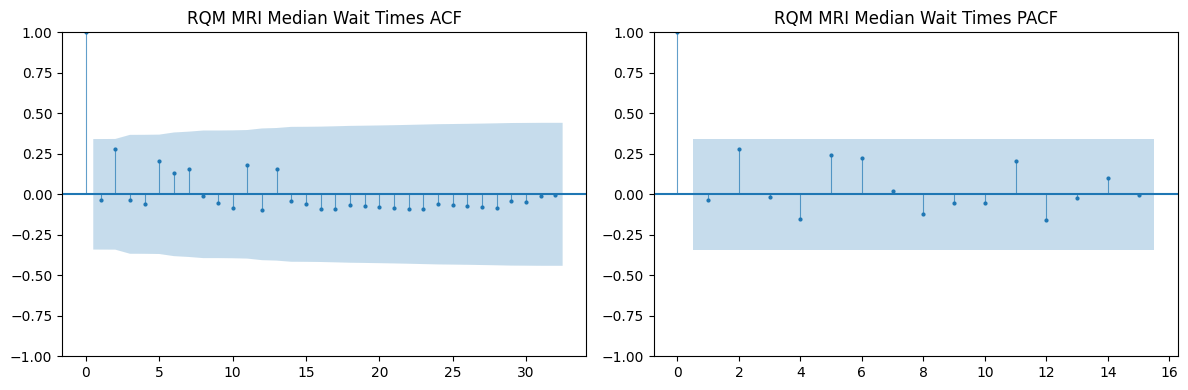

In [6]:
regions = df_mri['Org Code'].unique()
regions =['NT9', 'RQM']

plt.rcParams['lines.markersize'] = 1

for region in regions:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    data = df_mri[df_mri['Org Code']==region]
    data = data['MedianWaitDays'].to_numpy().flatten()
    plt.rcParams['lines.markersize'] = 1
    plot_acf(data, lags=len(data)-1, ax=axs[0], vlines_kwargs={'linewidth': 0.8, 'alpha':0.7})
    axs[0].set_title(f'{region} MRI Median Wait Times ACF')
    plot_pacf(data, lags=(len(data)/2)-1, ax=axs[1], vlines_kwargs={'linewidth': 0.8, 'alpha':0.7})
    axs[1].set_title(f'{region} MRI Median Wait Times PACF')
   
    for ax in axs:
        for line in ax.lines:
            line.set_markersize(2)

    plt.tight_layout()
    plt.show()